# Common geometric operations

Geometric operations refer to a set of methods that can be used to process and analyze geometric features, like points, lines and polygons. In the context of geographic data analysis, these operations allow us, for instance, to ask questions about how two or more geographic objects relate to each other: Do they intersect, touch, or overlap? Are they adjacent to one another? How far apart are they? With the tools bundled in `geopandas`, it is easy to perform these kind of operations which is the main focus of Chapter 6. As we delve into the geometric operations, you will discover that they form the foundation of many geospatial analyses, enabling insights that are often difficult to discern from non-spatial data alone.

In the following, we demonstrate some of the most common geometric manipulation functions available in `geopandas`. We will do this by continuing to explore the census tract data from Austin, Texas. Geometric manipulations are often useful e.g. when working with data related to administrative boundaries, as we often might need to transform or manipulate the geographic data in one way or another for further analysis and visualization purposes. Next, we will learn how to generate centroids, different outlines, and buffer zones for the polygons. Let's start by reading the census tract data into `GeoDataFrame`. In this case, we use data that we already manipulated a bit in the previous section (by calculating the area and population density):

In [1]:
import geopandas as gpd
from pathlib import Path

# Define path do the data
data_folder = Path("data/Austin")
fp = data_folder / "austin_pop_density_2019.gpkg"

# Read in the data and check the contents
data = gpd.read_file(fp)
data.head()

,pop2019,tract,area_km2,pop_density_km2,geometry
0,6070.0,002422,4.029772,1506.288778,"MULTIPOLYGON (((615643.488 3338728.496, 615645..."
1,2203.0,001751,1.532030,1437.961394,"MULTIPOLYGON (((618576.586 3359381.053, 618614..."
2,7419.0,002411,3.960344,1873.322161,"MULTIPOLYGON (((619200.163 3341784.654, 619270..."
3,4229.0,000401,2.181762,1938.341859,"MULTIPOLYGON (((621623.757 3350508.165, 621656..."
4,4589.0,002313,2.431208,1887.538658,"MULTIPOLYGON (((621630.247 3345130.744, 621717..."


For the purposes of geometric manipulations, we are mainly interested in the geometry column which contains the polygon geometries. Remember, that the data type of the geometry-column is `GeoSeries`. As we have mentioned earlier, the individual geometries are ultimately `shapely` geometric objects (e.g. `Point`, `LineString`, `Polygon`), and we can use all of `shapely`'s tools for geometric manipulations directly via `geopandas`. The following shows that the geometries in the `GeoSeries` are stored as `MultiPolygon` objects:

In [2]:
data["geometry"].head()

0    MULTIPOLYGON (((615643.488 3338728.496, 615645...
1    MULTIPOLYGON (((618576.586 3359381.053, 618614...
2    MULTIPOLYGON (((619200.163 3341784.654, 619270...
3    MULTIPOLYGON (((621623.757 3350508.165, 621656...
4    MULTIPOLYGON (((621630.247 3345130.744, 621717...
Name: geometry, dtype: geometry

In [3]:
# Check data type of the geometry column
type(data["geometry"])

geopandas.geoseries.GeoSeries

In [4]:
# Check data type of a value in the geometry column
type(data["geometry"].values[0])

shapely.geometry.multipolygon.MultiPolygon

Let's first plot the original geometries. We can use the built-in `.plot()` function in `geopandas` to plot the geometries, and `matplotlib.pyplot` to turn off axis lines and labels:

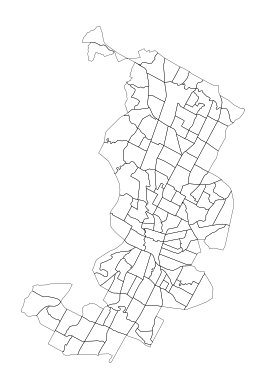

In [5]:
import matplotlib.pyplot as plt

data.plot(facecolor="none", linewidth=0.2)

plt.axis("off")
plt.show()

_**Figure 6.14**. Basic plot of the census tracts._

## Centroid

The centroid of a geometry is the geometric center of a given geometry (line, polygon or a geometry collection). Extracting the centroid of geometric features is useful in many cases. Geometric centroids can, for example, be used for locating text labels in visualizations. We can extract the center point of each polygon via the `centroid` attribute of the `geometry` column. The data should be in a projected coordinate reference system when calculating the centroids. If trying to calculate centroids based on latitude and longitude information, `geopandas` will warn us that the results are likely (slightly) incorrect. Our `GeoDataFrame` is in WGS 84 / UTM zone 14N (EPSG:32614) coordinate reference system (CRS) which is a projected one (we will learn more about these in the next section). Thus, we can directly proceed to calculating the centroids:

In [6]:
data.crs.name

'WGS 84 / UTM zone 14N'

In [7]:
data["geometry"].centroid.head()

0     POINT (616990.19 3339736.002)
1    POINT (619378.303 3359650.002)
2    POINT (620418.753 3342194.171)
3    POINT (622613.506 3351414.386)
4    POINT (622605.359 3343869.554)
dtype: geometry

We can also apply the method directly to the `GeoDataFrame` to achieve the same result using the syntax `data.centroid`. At the same time, we can also  plot the centroids for a visual check:

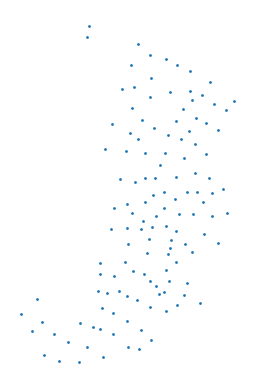

In [8]:
data.centroid.plot(markersize=1)

plt.axis("off")
plt.show()

_**Figure 6.15**. Basic plot of census tract centroids._

## Unary union

A unary union operation combines multiple geometric objects into a single, unified geometric shape. We can generate a joint outline for the administrative areas through creating a geometric union among all geometries. This can be useful, for example, for visualizing the outlines of a study area. The `.union_all()` returns a single geometry object, which is automatically visualized when running the code in a Jupyter Notebook:

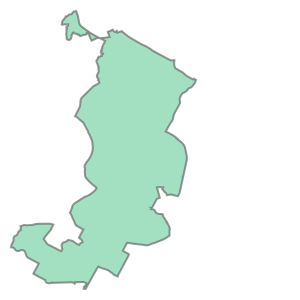

In [9]:
data.union_all()

_**Figure 6.16**. Union of all of census tract polygon geometries._

The `.union_all()` method returns a `shapely` polygon object out of the results. It is also possible to merge geometries using a method called `.dissolve()` that returns a `GeoDataFrame` as an output (with aggregated attribute information). Both the `.union_all()` and the `.dissolve()` support two different kind of algorithms to form the merged geometry: `"unary"` (the default) and `"coverage"` which is optimized for non-overlapping polygons and can be significantly faster to compute. As our data here, does not have any overlapping polygons, we can test how merging the geometries work with the `"coverage"` algorithm:

In [10]:
# Merge geometries using coverage algorithm
dissolved = data.dissolve(method="coverage")
dissolved.head()

,geometry,pop2019,tract,area_km2,pop_density_km2
0,"MULTIPOLYGON (((618353.957 3340531.11, 618350....",6070.0,002422,4.029772,1506.288778


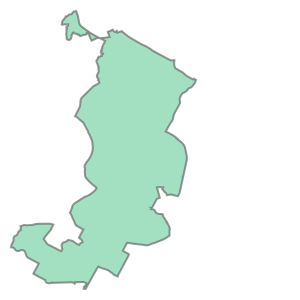

In [11]:
# Get the shapely geometry
dissolved.geometry[0]

***Figure 6.17.** Union of all polygon geometries using the dissolve -method.*

As a result, the `dissolved` variable now contains the merged geometry as well as the attribute information associated with it. When looking at the returned geometry, we can see that it is identical to the one returned by `.union_all()` method. Notice that by default the `.dissolve()` simply stores the first row of data as an attribute information. It is, however, possible to control how the attribute information should be aggregated/summarized, e.g. by summing the values. Read more information about this later from the section where we introduce more thoroughly the functionality of `.dissolve()`. 


## Bounding polygon

A bounding polygon, often referred to as a bounding box or envelope, is the smallest rectangular polygon that encloses a given geometry or a set of geometries. In simpler terms, it's like drawing the tightest possible rectangle around a shape, capturing all of its points within this rectangle. The bounding polygon is often used in spatial operations for preliminary filtering because it provides a computationally simple way to test for possible intersections or proximities between geometries that can be used to select data. There are different ways to extract a bounding polygon for a given geometry/geometries, such as axis-aligned *envelope*, *minimum rotated rectangle*, and *minimum bounding circle* which can all be extracted with `geopandas`.

In a `GeoDataFrame`, we can easily return the minimum axis-aligned bounding rectangle of geometries by using the `.envelope` attribute which returns the bounding rectangle for each geometry:

In [12]:
data.envelope.head()

0    POLYGON ((615643.488 3337909.895, 618358.033 3...
1    POLYGON ((618529.497 3358797, 620192.632 33587...
2    POLYGON ((619198.456 3340875.421, 621733.88 33...
3    POLYGON ((621599.087 3350329.32, 623714.365 33...
4    POLYGON ((621630.247 3343015.679, 624133.189 3...
dtype: geometry

In order to get the bounding rectangle for the whole layer, we  first create an union of all geometries using the `.union_all()` method, and then extract the bounding rectangle for that polygon using the `.envelope`:

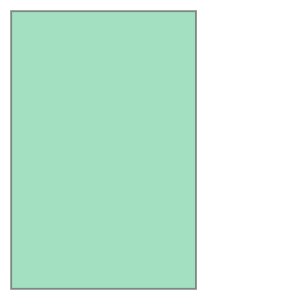

In [13]:
data.union_all().envelope

_**Figure 6.18**. Minimum bounding box for the census tracts._

Corner coordinates of the bounding box for a `GeoDataFrame` can be fetched via the `total_bounds` attribute: 

In [14]:
data.total_bounds

array([ 608125.39429998, 3337909.89499998,  629828.38850021,
       3370513.68260002])

The `bounds` attribute returns the bounding coordinates of each feature:

In [15]:
data.bounds.head()

,minx,miny,maxx,maxy
0,615643.4875,3.337910e+06,618358.0327,3.341257e+06
1,618529.4971,3.358797e+06,620192.6319,3.360614e+06
2,619198.4560,3.340875e+06,621733.8796,3.343443e+06
3,621599.0866,3.350329e+06,623714.3655,3.352436e+06
4,621630.2470,3.343016e+06,624133.1887,3.345131e+06


Similarly, it is possible to get the *minimum rotated rectangle* and *minimum bounding circle*  with `geopandas` by using the `.minimum_rotated_rectangle()` and `.minimum_bounding_circle()` methods respectively. Here, we first merge all the geometries using the `.dissolve()` method as shown previously, and then use the merged geometry for getting the minimum bounding polygon:

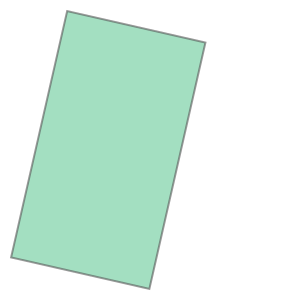

In [16]:
data.dissolve().minimum_rotated_rectangle().geometry[0]

_**Figure 6.19**. Minimum rotated rectangle for the census tracts._

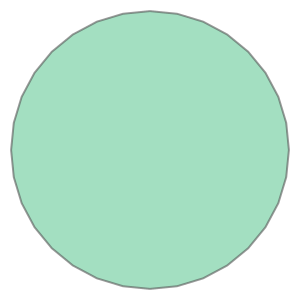

In [17]:
data.dissolve().minimum_bounding_circle().geometry[0]

_**Figure 6.20**. Minimum bounding circle for the census tracts._

As can be seen from the geometries above, the *minimum rotated rectangle* can rotate around the input geometries and aims to encircle them as tightly as possible. The *minimum bounding circle* then again creates a circle around the geometries in a way that each geometry is enclosed by the circle. Depending on the use case, all of these methods may come handy when working with geographic data.

### Convex hull

A bit more detailed delineation of the data extent can be extracted using a convex hull which represents the smalles possible polygon that contains all points in an object. To illustrate this, imagine stretching a rubber band around a set of points. Once released, the rubber band would snap into the shape of the convex hull, which wraps around the outermost points. Thus, it excludes points that are "indentations" in the shape. In geocomputation, the convex hull is used for various tasks as it can be used to easily provide a simplified representation of a set of points or a more complex geometry. 

In `geopandas`, we can use an attribute `.convex_hull` to return the convex hull of geometries. Similarly as with unary union, if we apply the convex hull method on the whole `GeoDataFrame`, we will get a GeoSeries containing a convex hull for each polygon separately:

In [18]:
data.convex_hull.head()

0    POLYGON ((616870.883 3337909.895, 616852.964 3...
1    POLYGON ((619496.705 3358797, 618962.703 33590...
2    POLYGON ((619848.5 3340875.421, 619811.394 334...
3    POLYGON ((622145.426 3350329.32, 622132.429 33...
4    POLYGON ((623931.77 3343015.679, 622426.307 33...
dtype: geometry

In order to create a convex hull for the whole extent, we need to first create an union of all polygons. 

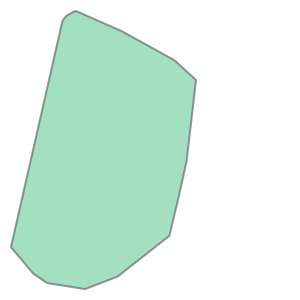

In [19]:
data.union_all().convex_hull

_**Figure 6.21**. Smallest convex polygon for the census tracts._

### Concave hull

A concave hull is a polygon that encloses a set of points but, unlike the convex hull, is allowed to have concavities. In simpler terms, while a convex hull wraps around the outermost points in the tightest convex manner (like a stretched rubber band), a concave hull can bend inward to more closely follow the distribution of the points, providing a boundary that might be more representative of the actual shape of the dataset.

In `geopandas`, we can create a concave hull of a `GeoDataFrame` by calling `.concave_hull()` method. Again, if we apply the concave hull method on the whole `GeoDataFrame`, we will get a `GeoSeries` containing a concave hull for each polygon separately:

In [20]:
data.concave_hull().head()

0    POLYGON ((616686.447 3341251.083, 616689.559 3...
1    POLYGON ((619414.904 3360602.695, 619418.528 3...
2    POLYGON ((620165.029 3343417.634, 620177.845 3...
3    POLYGON ((622361.001 3352408.88, 622364.565 33...
4    POLYGON ((621654.405 3344983.596, 621630.247 3...
dtype: geometry

If we want to return the concave hull for all geometries, we need to do a couple of tricks because this functionality does not come directly from `shapely` but is implemented only on `geopandas`. We first use `.dissolve()` method (see more information about this in separate section below) which does similar thing as `.union_all()` but returns a `GeoDataFrame` as a result before calling the `concave_hull()` function:

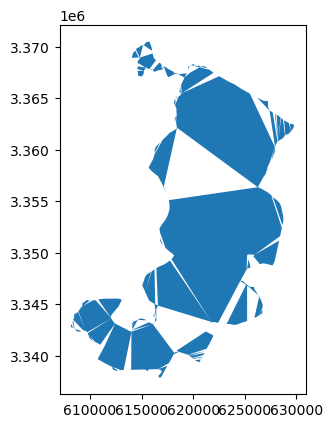

In [21]:
concave_hull = data.dissolve().concave_hull()
concave_hull.plot();

_**Figure 6.22**. A concave hull applied with default settings for the census tracts produces interesting shapes._

As we can see, the exact shape of a concave hull has been simplified but the shape looks quite weird and has gaps between the shapes. Because calculating the concave hull is a much more complicated operation than the previous ones, there are actually a couple of parameters which we can use to control the shape of the output. Parameters `ratio` and `allow_holes` can be used in situations where the convex hull is too general or doesn't provide a realistic boundary for a set of points, like when capturing the outline of irregularly shaped clusters. In `geopandas`, the hull is constructed by removing border triangles of a process called Delaunay Triangulation of the points based on specific criteria. We can very easily improve the shape of the convex hull by adjusting the `ratio` parameter which accepts a value between 0.0 - 1.0. The higher the number, the fewer the number of vertices will be kept in the output. In the following, we can see how changing this value influences the end result. Let's first calculate the concave hull by passing different values for the `ratio` parameter:

In [22]:
# Create GeoDataFrame of the union
gdf_union = data.dissolve()

# Ratio 0.05
concave_hull_a = gdf_union.concave_hull(ratio=0.05)

# Ratio 0.2
concave_hull_b = gdf_union.concave_hull(ratio=0.2)

# Ratio 0.4
concave_hull_c = gdf_union.concave_hull(ratio=0.4)

Now, let's plot these geometries side by side, so it is easy to compare them:

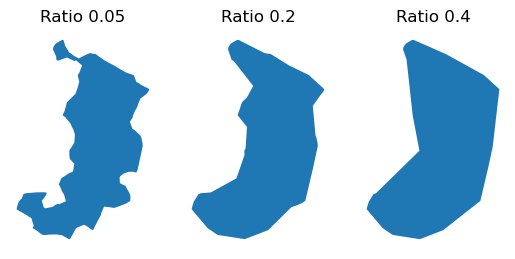

In [23]:
import matplotlib.pyplot as plt

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

# Plot side by side
concave_hull_a.plot(ax=ax1)
concave_hull_b.plot(ax=ax2)
concave_hull_c.plot(ax=ax3)

# Remove axis texts
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")

# Add titles
ax1.set_title("Ratio 0.05")
ax2.set_title("Ratio 0.2")
ax3.set_title("Ratio 0.4");

_**Figure 6.23**. A concave hull with different `ratio` settings produces a varying level of simplification of the input geometry._

As we can see, by adjusting the `ratio` parameter, we can have a good control for determining how detailed geometries we get as an output of the concave hull.

## Simplifying geometries

The previous example with concave hull showed the basic idea of how we can simplify the shape of a given Polygon. Geometric simplification is a useful process especially when visualizing data that contains very detailed geometries. An function in `geopandas` called `.simplify()` can also be used to simplify geometries. In comparison to the concave hull, this function also works with `LineString` geometries in addition to polygons. The `tolerance` parameter can be used to control the level of simplification. The units for this parameter follow the input coordinates. This means that e.g. with `tolerance=1000` the tolerance stands for 1000 meters because our input data is in a projected (metric) coordinate refence system (which we covered in Chapter 5.3). However, in case the input data would have lat/lon coordinates, the tolerance should be passed in as decimal degrees. 

Under the hood, the `.simplify()` uses a Douglas-Peucker algorithm to recursively split the original line into smaller parts and connects these parts’ endpoints by a straight line. Then, it removes all points whose distance to the straight line is smaller than the tolerance. It does not move any points and it always preserves endpoints of the original line or polygon. The following shows how we can generate a simplified version of the polygons of the Austin cencus data, first applied to individual polygons, and then to the outline extent of the whole dataset:

In [24]:
data.simplify(tolerance=1000).head()

0    POLYGON ((615643.488 3338728.496, 616689.559 3...
1    POLYGON ((619496.705 3358797, 619418.528 33606...
2    POLYGON ((619200.163 3341784.654, 620177.845 3...
3    POLYGON ((621623.757 3350508.165, 622387.916 3...
4    POLYGON ((621630.247 3345130.744, 624133.189 3...
dtype: geometry

In a similar manner as before, we can easily apply `.simplify()` to the extent of all geometries by first getting the unary union of the input geometries:

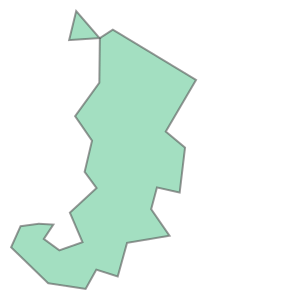

In [25]:
data.union_all().simplify(tolerance=1000)

_**Figure 6.24**. Simplified union of the census tract polygons._

## Buffer

A buffer refers to a geometric operation that creates a zone around a given geometry (or geometries), usually representing a certain distance from the shape. This zone/buffer can be visualized as an expanded area around the original shape, or conversely, a contracted area inside the shape if the buffer distance is negative. Buffering is a common spatial operation that has a multitude of use cases in spatial analyses. For example, in transport network analyses, it is good to fetch the transport network also from outside the study area in order to capture routes that go beyond the study area border. 

In `geopandas`, we can easily create buffers using the method `.buffer()` that can be applied to all geometries at once in a similar manner as our previous examples. The `distance` parameter in the `.buffer()` function defines the radius of the buffer (according to the coordinate reference system of the data). In the following, we will apply a 1000 meter buffer on the entire 'GeoDataFrame` which will produce separate buffers for each census tract:

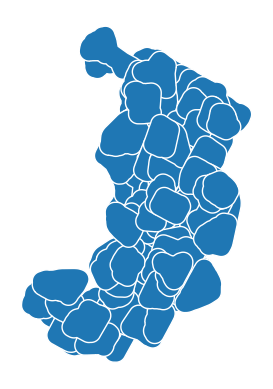

In [26]:
# 1000 m buffer for each polygon
data.buffer(1000).plot(edgecolor="white")

plt.axis("off")
plt.show()

_**Figure 6.25**. 1km buffer for each census tract._

If we want only one buffer for the whole area, we first need to combine the geometries into one object before the buffer analysis: 

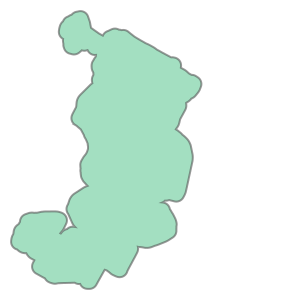

In [27]:
# 1000 m buffer for each polygon
data.union_all().buffer(1000)

_**Figure 6.26**. 1km buffer for each census tract._

Buffer can be used with different geometry types, also with `Point` and `LineString` objects. It is good to notice that if you apply a buffer for points or polygons, the resulting geometry will always be a `Polygon`. 

## Dissolving and merging geometries

Spatial data aggregation refers to combining geometries into coarser spatial units based on some attributes. The process may also include the calculation of summary statistics. In Part I of the book, we learned how to group and aggregate data with `pandas` using the `.groupby()` method. In `geopandas`, there is a method called `.dissolve()` that groups the data based on a specific attribute column and then produces an union of the geometries for each group in that attribute. At the same time, we can also get summary statistics of the attributes. 

To demonstrate how dissolve works with our sample data, let's create create a new column to our `GeoDataFrame` to indicate census tracts with above average population density. We can do this by adding a new empty column `dense` and adding values that indicate above and below average population densities per census tract:

In [28]:
# Create a new column and add a constant value
data["dense"] = 0

# Filter rows with above average pop density and update the column dense
data.loc[data["pop_density_km2"] > data["pop_density_km2"].mean(), "dense"] = 1

After this step, we should have multiple rows with numbers `0` and `1`, where the number one indicates a densily populated area. We can easily check how many densily populated census tracts we got by using the `.value_counts()` method from pandas:

In [29]:
data.dense.value_counts()

dense
0    86
1    44
Name: count, dtype: int64

Now we can use this `dense` column to dissolve the data into two groups using the `.dissolve()` function. At the same time, we can sum up the values in `pop2019` and the `area_km2` columns by using the `aggfunc` parameter. The aggregation requires that we select the numerical columns that we want to include in the output (which are indicated with the list of column names below):

In [30]:
# Conduct the aggregation
dissolved = data[["pop2019", "area_km2", "dense", "geometry"]].dissolve(
    by="dense", aggfunc="sum"
)
dissolved

,geometry,pop2019,area_km2
dense,,,
0,"MULTIPOLYGON (((614108.23 3339640.551, 614288....",368992.0,231.131494
1,"MULTIPOLYGON (((612263.531 3338931.8, 612265.2...",242943.0,71.234570


The dissolved data should have as many rows of data as there were unique values in the column - one row for each unique value. Our data have been compressed into two geometric objects and the column used for dissolving the data can now be found in the index. Attribute columns represent the sum of the values per group. We can reset the index and insert the categorical information into a new column after which we can do a quick visualization of the result:

In [31]:
dissolved = dissolved.reset_index()

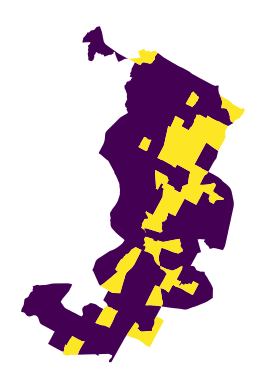

In [32]:
dissolved.plot(column="dense")

plt.axis("off")
plt.show()

_**Figure 6.27**. Dissolved census tract geometries._

#### Question 6.5

Combining your `pandas` and `geopandas` skills, create a 500m buffer zone around the dense areas in Austin and plot a simple map of this zone.

In [33]:
# Use this cell to enter your solution.

<Axes: >

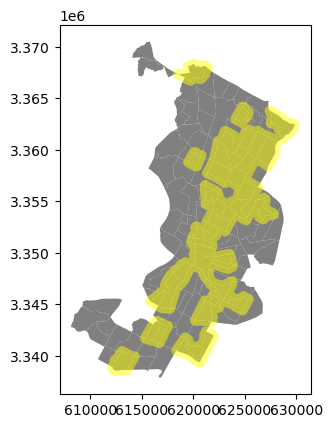

In [34]:
# Solution

# Plot the admin borders as background
ax1 = data.plot(color="grey")

# Plot the buffer zone of dense areas on top
dissolved.loc[dissolved["dense"] == 1].buffer(500).plot(
    ax=ax1, alpha=0.5, color="yellow"
)

## Changing the active geometry in a GeoDataFrame

In the previous examples, we did not really store the manipulated geometries anywhere, as we mostly printed or plotted the results of the geometric operations directly to the screen. Next, we want to discuss briefly about different ways to store the results of the geometric operations into `GeoDataFrame`, and how you can change/update the active geometry of the `GeoDataFrame` for representing the geometries in your data. In some cases, such as when calculating the centroids in the previous examples, you might actually want to save the centroids into your `GeoDataFrame`. This is useful, because you can then continue processing or analysing the data based on these geometries. Storing and updating geometries in your `GeoDataFrame` can be done easily with `geopandas`, and in fact, you can have multiple columns that contain geometries. There are a couple of approaches to update the geometries of your `GeoDataFrame`:

1. Overwrite the existing geometries in the `geometry` column by storing the new (manipulated) geometries into it.
2. Create a new column (e.g. `centroid`) and store the new geometries into this one. Then activate/set this column as the "active geometry" for your `GeoDataFrame`. In this way, you can have multiple simultaneous columns containing geometries in a `GeoDataFrame`, which can be very handy!

Some important remarks about these approaches: The option 1 is very easy to do, but the downside of it is the fact that you do not have access to the original geometries (e.g. polygons) anymore. The option 2 requires a couple of steps, but the good side of it, is that you can easily swap between the original geometries and the centroids in your data. However, when saving the geographic data into disk, you can in most cases only include one column with geometries. Hence, latest at this stage, you need to decide which column is used for representing the geometric features in your data. An exception to this is `GeoParquet` file format which supports saving multiple geometry columns. In the following, we demonstrate how to do both of the options mentioned previously. Let's start by showing how you can overwrite the existing geometries with centroids:

In [35]:
# Make a copy
option_1 = data.copy()
option_1["geometry"].head(2)

0    MULTIPOLYGON (((615643.488 3338728.496, 615645...
1    MULTIPOLYGON (((618576.586 3359381.053, 618614...
Name: geometry, dtype: geometry

In [36]:
# Update the geometry column with centroids
option_1["geometry"] = option_1.centroid
print(option_1.head(2))

   pop2019   tract  area_km2  pop_density_km2                        geometry  \
0   6070.0  002422  4.029772      1506.288778   POINT (616990.19 3339736.002)   
1   2203.0  001751  1.532030      1437.961394  POINT (619378.303 3359650.002)   

   dense  
0      0  
1      0  


As we can see, now the geometries in the `geometry` column were replaced and populated with `Point` objects that represent the centroids of the polygons. With this approach, you cannot anymore access the original polygon geometries.

The second option is to create a new column for storing the centroids and then use this column as the source for representing geometries of the given `GeoDataFrame`:

In [37]:
# Make a copy and Create a column with centroids
option_2 = data.copy()
option_2["centroid"] = data.centroid
option_2.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry,dense,centroid
0,6070.0,002422,4.029772,1506.288778,"MULTIPOLYGON (((615643.488 3338728.496, 615645...",0,POINT (616990.19 3339736.002)
1,2203.0,001751,1.532030,1437.961394,"MULTIPOLYGON (((618576.586 3359381.053, 618614...",0,POINT (619378.303 3359650.002)


Now we have two columns in our `GeoDataFrame` that contain geometries. By default, `geopandas` always uses the `geometry` column as an active geometry when e.g. reading data from a file. However, we can easily change the active geometry with `.set_geometry()` method which can be used to tell `geopandas` to use another column with geometries as the source for geometry data:

In [38]:
# Use centroids as the GeoDataFrame geometries
option2 = option_2.set_geometry("centroid")
option2.head(2)

,pop2019,tract,area_km2,pop_density_km2,geometry,dense,centroid
0,6070.0,002422,4.029772,1506.288778,"MULTIPOLYGON (((615643.488 3338728.496, 615645...",0,POINT (616990.19 3339736.002)
1,2203.0,001751,1.532030,1437.961394,"MULTIPOLYGON (((618576.586 3359381.053, 618614...",0,POINT (619378.303 3359650.002)


Nothing seem to have changed in the data itself, which is good because we did not want to modify any of it. However, when we take a look at the `.geometry.name` attribute of the `GeoDataFrame`, we can see that the name of the column used as active geometry has actually changed:

In [39]:
option2.geometry.name

'centroid'

We can still confirm this by plotting our `GeoDataFrame` which now returns a map with points:

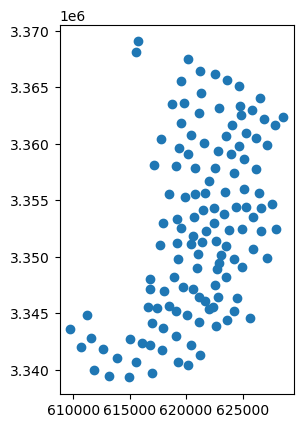

In [40]:
option2.plot();

_**Figure 6.28**. Centroids of the census tracts stored in a GeoDataFrame._

By following this approach, you can easily change the active `geometry` for your `GeoDataFrame` based on data stored in different columns. This can be highly useful when manipulating geometries as you can store the geometries from different computational steps into a same `GeoDataFrame` without a need to make multiple copies of the data. However, we recommend to be a bit careful when storing multiple columns with geometries, as it is possible that you accidentally use a different column as active geometry than what you have planned to do, which can cause confusion and problems with your analyses. Always remember the name the columns intuitively which can help avoiding issues and confusion in your analyses!

## Footnotes

[^gpd_dissolve]: <https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html>